In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_pickle("train_engineered.pkl")

In [3]:
test_data = pd.read_pickle("test_engineered.pkl")

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [7]:
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score

In [20]:
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score,f1_score

In [8]:
def model_results(X_train, y_train, X_test, y_test, model):
    # Fit the training model to the training set
    model.fit(X_train, y_train)
    
    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    probs = model.predict_proba(X_test)
    
    # Print the accuracy and roc_auc_score performance metric
    print("Accuracy: ", accuracy_score(y_test, predicted))
    print("AUC: ", roc_auc_score(y_test, probs[:,1]))
    print("-----")
    # Print the classification report and confusion matrix
    print (ConfusionMatrixDisplay.from_predictions(y_test, predicted))
    print (classification_report(y_test, predicted))

## Training with missing data

In [25]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [10]:
X = train_data.drop('isFraud',axis=1)

In [11]:
y = train_data['isFraud']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

In [13]:
random_forest = RandomForestClassifier(random_state=42)

Accuracy:  0.9801622244047821
AUC:  0.9376630103583324
-----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113957
           1       0.95      0.46      0.62      4151

    accuracy                           0.98    118108
   macro avg       0.97      0.73      0.80    118108
weighted avg       0.98      0.98      0.98    118108



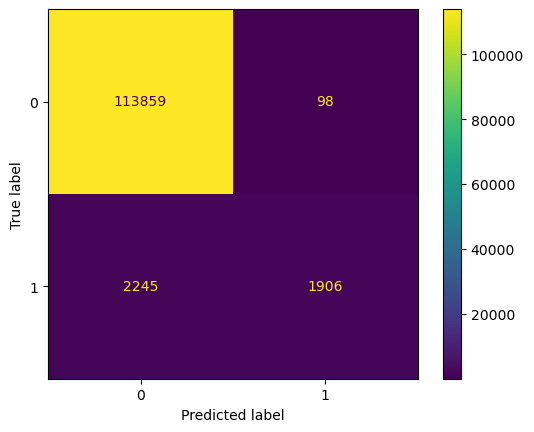

In [14]:
model_results(X_train, y_train, X_test, y_test,random_forest)

In [16]:
rf = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=101,n_jobs=-1)

In [23]:
def stratified_kfold_results(X, y, model, n_splits=5):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    aucs = []
    f1_scores = []
    pr_auc_scores = []
    
    fold = 1
    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        probs = model.predict_proba(X_val_fold)[:, 1]
        
        acc = accuracy_score(y_val_fold, preds)
        auc = roc_auc_score(y_val_fold, probs)
        f1 = f1_score(y_val_fold, preds)
        pr_auc = average_precision_score(y_val_fold,probs)
        
        accuracies.append(acc)
        aucs.append(auc)
        f1_scores.append(f1)
        pr_auc_scores.append(pr_auc)

        print(f"--- Fold {fold} ---")
        print(f"Accuracy: {acc:.4f}")
        print(f"ROC-AUC:  {auc:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        print(classification_report(y_val_fold, preds))
        fold += 1

    print("========== AVERAGED METRICS ==========")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Mean ROC-AUC:  {np.mean(aucs):.4f}")
    print(f"Mean F1-score: {np.mean(f1_scores):.4f}")
    print(f"Mean PR_AUC_score: {np.mean(pr_auc_scores):.4f}")


In [24]:
stratified_kfold_results(X_train,y_train,rf,n_splits=5)

--- Fold 1 ---
Accuracy: 0.9788
ROC-AUC:  0.9395
F1-score: 0.5729
PR-AUC: 0.7401
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     91184
           1       0.97      0.41      0.57      3303

    accuracy                           0.98     94487
   macro avg       0.97      0.70      0.78     94487
weighted avg       0.98      0.98      0.97     94487

--- Fold 2 ---
Accuracy: 0.9792
ROC-AUC:  0.9351
F1-score: 0.5851
PR-AUC: 0.7395
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     91184
           1       0.97      0.42      0.59      3303

    accuracy                           0.98     94487
   macro avg       0.98      0.71      0.79     94487
weighted avg       0.98      0.98      0.98     94487

--- Fold 3 ---
Accuracy: 0.9786
ROC-AUC:  0.9331
F1-score: 0.5689
PR-AUC: 0.7339
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     

In [28]:
from xgboost import XGBClassifier

In [29]:
xg = XGBClassifier(n_estimators=128, max_depth=2, learning_rate=1, objective='binary:logistic',random_state=101)

Accuracy:  0.9749805262979646
AUC:  0.8800885987190809
-----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113957
           1       0.82      0.37      0.51      4151

    accuracy                           0.97    118108
   macro avg       0.90      0.68      0.75    118108
weighted avg       0.97      0.97      0.97    118108



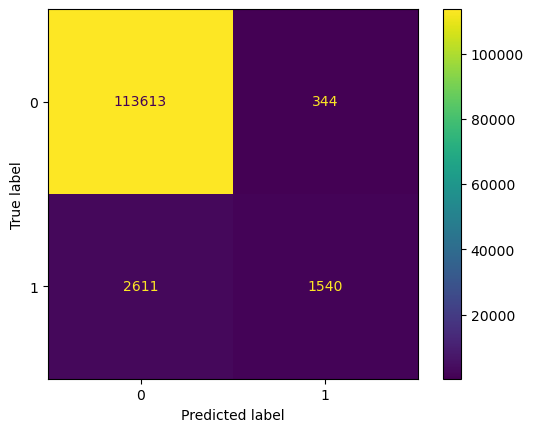

In [30]:
model_results(X_train, y_train, X_test, y_test,xg)

In [32]:
neg_count = y.value_counts()[0] 
pos_count = y.value_counts()[1] 
scale_pos_weight_value = neg_count / pos_count 

In [33]:
XGB_model = XGBClassifier(n_estimators=200, 
                          max_depth=5, 
                          learning_rate=0.1, 
                          objective='binary:logistic',
                          subsample=0.8,
                          colsample_bytree=0.8,
                          gamma=0.1,
                          n_jobs=-1,
                          use_label_encoder=False,
                          eval_metric='logloss',
                          scale_pos_weight=scale_pos_weight_value,
                          random_state=101)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [34]:
stratified_kfold_results(X, y, XGB_model, n_splits=5)

--- Fold 1 ---
Accuracy: 0.8864
ROC-AUC:  0.9248
F1-score: 0.3295
PR-AUC: 0.6116
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    113976
           1       0.21      0.80      0.33      4132

    accuracy                           0.89    118108
   macro avg       0.60      0.84      0.63    118108
weighted avg       0.96      0.89      0.92    118108

--- Fold 2 ---
Accuracy: 0.8865
ROC-AUC:  0.9270
F1-score: 0.3342
PR-AUC: 0.6174
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    113976
           1       0.21      0.81      0.33      4132

    accuracy                           0.89    118108
   macro avg       0.60      0.85      0.64    118108
weighted avg       0.97      0.89      0.92    118108

--- Fold 3 ---
Accuracy: 0.8884
ROC-AUC:  0.9240
F1-score: 0.3338
PR-AUC: 0.6147
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    1

In [35]:
import lightgbm as lgb

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [47]:
def clean_column_names(df):
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
    return df

In [37]:
lgb_model = lgb.LGBMClassifier(objective='binary',n_estimators=128,learning_rate=0.1,num_leaves=31,is_unbalance=True)

In [50]:
X_cleaned = clean_column_names(train_data)

In [51]:
print(X_cleaned.columns.to_list())

['TransactionID', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C3', 'C5', 'D1', 'D3', 'D4', 'D5', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V10', 'V12', 'V14', 'V15', 'V19', 'V23', 'V25', 'V27', 'V35', 'V37', 'V44', 'V46', 'V47', 'V53', 'V55', 'V56', 'V61', 'V66', 'V75', 'V77', 'V78', 'V82', 'V86', 'V95', 'V98', 'V99', 'V104', 'V107', 'V108', 'V109', 'V111', 'V112', 'V114', 'V115', 'V117', 'V118', 'V120', 'V121', 'V122', 'V123', 'V124', 'V129', 'V130', 'V131', 'V135', 'V136', 'V138', 'V139', 'V141', 'V144', 'V146', 'V148', 'V161', 'V166', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V184', 'V187', 'V188', 'V194', 'V205', 'V208', 'V209', 'V210', 'V214', 'V215', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V238', 'V240', 'V241', 'V250', 'V260', 'V270', 'V281', 'V282', 'V283', 'V284', 'V286', 'V288', 'V290', 'V291

In [52]:
X_1 = X_cleaned.drop('isFraud',axis=1)

In [53]:
y_1 = X_cleaned['isFraud']

In [54]:
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_1,y_1,test_size=0.2, random_state=101)

Accuracy:  0.8841060724083043
AUC:  0.9302188334458369
-----
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    113957
           1       0.21      0.81      0.33      4151

    accuracy                           0.88    118108
   macro avg       0.60      0.85      0.63    118108
weighted avg       0.96      0.88      0.92    118108



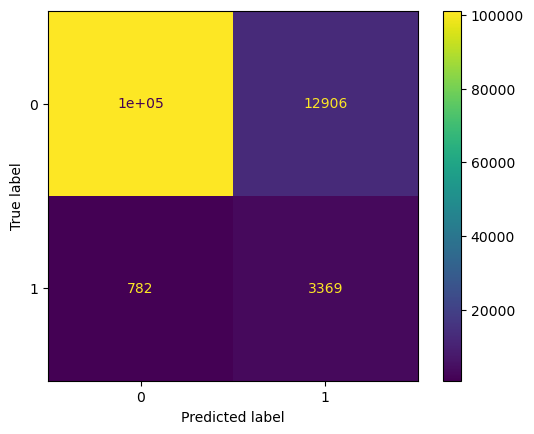

In [55]:
model_results(X_train_cleaned, y_train_cleaned, X_test_cleaned, y_test_cleaned,lgb_model)

In [56]:
lgb_model_kfold = lgb.LGBMClassifier(objective='binary',n_estimators=128,learning_rate=0.1,num_leaves=31,is_unbalance=True,max_depth=6)

In [57]:
stratified_kfold_results(X_1, y_1, lgb_model_kfold, n_splits=5)

--- Fold 1 ---
Accuracy: 0.8770
ROC-AUC:  0.9177
F1-score: 0.3115
PR-AUC: 0.5931
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113976
           1       0.19      0.80      0.31      4132

    accuracy                           0.88    118108
   macro avg       0.59      0.84      0.62    118108
weighted avg       0.96      0.88      0.91    118108

--- Fold 2 ---
Accuracy: 0.8776
ROC-AUC:  0.9197
F1-score: 0.3152
PR-AUC: 0.5922
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113976
           1       0.20      0.80      0.32      4132

    accuracy                           0.88    118108
   macro avg       0.59      0.84      0.62    118108
weighted avg       0.96      0.88      0.91    118108

--- Fold 3 ---
Accuracy: 0.8780
ROC-AUC:  0.9172
F1-score: 0.3122
PR-AUC: 0.5945
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    1